In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from termcolor import colored
from scipy.stats import gamma

# Functions

In [2]:
def misprediction_rate(dataset):
    na_val = np.array(dataset['nonrejected_accuracy'])
    # value of nonrejected accuracy when n_rej samples have been rejected
    n = len(na_val)
    m_list = []
    for i in range(n):
        # (miscl. over all accepted) * (number of accepted samples) / tot samples
        m = (1 - na_val[i]) * (n-i) / n
        m_list.append(m)
    return np.array(m_list)


In [3]:
def fit_tau(data, X_test, dist_dict, metric, n_samples, max_rej_fraction, max_error):
    
    # compute distance between test examples and counterfactuals
    #dist_dict = compute_distance_from_counterfactual(X_test, expl_list)

    # fit gamma distribution and sample data
    alpha, loc, beta = gamma.fit([d for d in dist_dict.values() if d != np.inf])
    candidate_tau = gamma.rvs(alpha, loc, beta, size = n_samples)

    miscl_by_r = misprediction_rate(data)
    
    m_max = 0
    tau = np.inf
    n_rej_final = 0
    n =  X_test.shape[0]
    for t in candidate_tau:
        # check number of instances that will be rejected, i.e., all those with distance < t
        rej = [x for x, d in dist_dict.items() if d < t]
        n_rej = len(rej)
        rej_rate = n_rej / n
        
        # constraints: 1) rejection rate below thr and 2) mispredictions below thr
        if (rej_rate < max_rej_fraction) & (miscl_by_r[n_rej] < max_error):
            m = data[metric][n_rej] 
            if m > m_max:
                m_max = m
                n_rej_final = n_rej
                tau = t
            elif (m == m_max) & (t < tau):
                n_rej_final = n_rej
                tau = t

    base = data[metric][0]
    frac_rejected = n_rej_final / n
    return base, tau, m_max, frac_rejected, n_rej_final


In [4]:
def get_rejected_instances(res, d, m, max_rej_fraction = 0.6, max_error = 0.3, n_samples = 100):
    X_test = res[d]['original_data']
    dist_dict = res[d]['min_distances']
    base, tau, m_max, rej_rate, n_rej = fit_tau(res[d], X_test, dist_dict, m, n_samples, max_rej_fraction, max_error)
    print('Rejection rate: ', rej_rate)
    print('N of rejected samples: ', n_rej)
    x_rej_list = res[d]['rejected_samples'][n_rej]
    return x_rej_list

In [5]:
def explain_rejection(res, d, i):
    x = res[d]['explanation'][i]
    n_c_classes = len(x.crules.keys())
    class_map = res[d]['class_values_map']

    X_test = res[d]['original_data']

    # Rule
    text = 'The instance '+ colored('x = '+str(i), 'green') +' of the dataset '+colored('\x1B[3m'+d.upper()+'\x1B[0m', 'green')+' has been ' + colored('REJECTED', 'red', attrs=['bold']) + '.\n' 
    text += 'In fact, it would have been classified by the black-box as '+ colored(str(x.rule.class_name) + '='+ str(x.bb_pred), 'green') + ' with ' + colored(str(round(max(x.bb_pred_proba), 2)), 'green') +  ' predicted probability, '
    text += '\nbut ' + colored(str(n_c_classes)+' counterfactuals', 'blue', attrs=['bold']) + ' of different classes were found in close proximity:'
    #print(text)

    # counterfactuals
    j = 1
    for c in x.deltas.keys():
        item = str(j) + ') ' + str(x.rule.class_name) + '=' + str(x.crules[c][0].cons) + ': '
        text += '\n' + colored(item, 'blue')
        probs = {v: round(x.c_pred_proba[c][0][k],2) for k, v in class_map.items()}
        probs[x.crules[c][0].cons] = colored(str(probs[x.crules[c][0].cons]), 'blue')
        #print(*[str(k) + ':' + str(v) for k,v in probs.items()], sep=',')
        #print('\t\x1B[3mPredicted probabilities:\x1B[0m '+np.array2string(x.c_pred_proba[c][0], precision=2, separator=', '))
        text += '\n\t\x1B[3mPredicted probabilities:\x1B[0m '#+ *[str(k) + ': ' + str(v) + ', ' for k,v in probs.items()]
        for k,v in probs.items():
            text += str(k) + ': ' + str(v) + ', '
        text += '\n\t\x1B[3mChanges needed:\x1B[0m '
        for cond in x.deltas[c][0]:
            att = cond.att
            original = X_test.loc[i][att]
            text +='\n\t\t- '+str(cond) + '(original value:' + str(round(original, 2)) + ')'
        j +=1
    return text

# Classification

In [204]:
clf_res = pd.read_csv('Results/classification_results.csv', header=[0,1])
clf_res = clf_res.rename(columns={"Unnamed: 0_level_0":"Dataset", "Unnamed: 0_level_1":"Metric"})
# last = clf_res.iloc[6]
# df = clf_res.drop([6])
# for cval, dtype in [('accuracy_score', 'float64'), ('f1_score', 'float64'),  ('roc_auc_score', 'float64')]:
#     df.loc[:, pd.IndexSlice[:, cval]] = (
#         df.loc[:, pd.IndexSlice[:,cval]].astype(dtype))
clf_res


Dataset             abalone                                          \
          Metric      accuracy_score            f1_score       roc_auc_score   
0  MLPClassifier  0.6519138755980861  0.6507526043907049  0.8354209680460948   
1   RandomForest  0.6196172248803827  0.6119688806279729   0.801938770652477   
2            SVC   0.638755980861244  0.6440032467916681  0.8290574787694338   
3         TabNet  0.5203349282296651  0.5211324464683403    0.75284281589471   
4        XGBoost  0.6411483253588517  0.6406888077520487   0.821926796131792   
5            max  0.6519138755980861  0.6507526043907049  0.8354209680460948   
6       best_clf       MLPClassifier       MLPClassifier       MLPClassifier   

                adult                                           \
       accuracy_score             f1_score       roc_auc_score   
0  0.7858445217967843   0.2955288985823337  0.6050887494669802   
1  0.8463451019393337   0.6245443499392467  0.8928206076147716   
2   0.753522294049395  0.07467330429371499  0.6333981675576537   
3  0.8426984916293718   0.6317423360496702  0.8975789214762867   
4  0.8713741090667992   0.7169948942377826  0.9270493752022243   
5  0.8713741090667992   0.7169948942377826  0.9270493752022243   
6             XGBoost              XGBoost             XGBoost   

               compas                                          german_credit  \
       accuracy_score            f1_score       roc_auc_score accuracy_score   
0  0.6646382691007438  0.6439339554917444  0.7332940963419051            0.7   
1  0.6757944557133199  0.6741420319401971  0.7299354007294971           0.73   
2   0.718052738336714  0.7112188365650969  0.7801370276469878            0.7   
3  0.6700473292765382  0.6529160739687055  0.7407543837505808           0.55   
4  0.7068965517241379  0.7013434378229418   0.783775824159743          0.725   
5   0.718052738336714  0.7112188365650969   0.783775824159743           0.73   
6                 SVC                 SVC             XGBoost   RandomForest   

                                                        student  \
              f1_score        roc_auc_score      accuracy_score   
0                  0.0   0.4122619047619048  0.6598870056497175   
1  0.47058823529411764   0.7616071428571428  0.7288135593220338   
2                  0.0  0.46214285714285713  0.6576271186440678   
3   0.3835616438356165   0.5414285714285715  0.7186440677966102   
4   0.5045045045045046   0.7770238095238096  0.7672316384180791   
5   0.5045045045045046   0.7770238095238096  0.7672316384180791   
6              XGBoost              XGBoost             XGBoost   

                                                         wine  \
             f1_score       roc_auc_score      accuracy_score   
0  0.6045724588184195  0.7845333426432172  0.5357142857142857   
1  0.7168965943954739   0.874478320185198  0.5418367346938775   
2  0.6161105582972924  0.8069406824698895  0.5948979591836735   
3  0.7117256654414601  0.8690551129571833   0.523469387755102   
4  0.7598222840369272   0.910310386334371  0.7173469387755103   
5  0.7598222840369272   0.910310386334371  0.7173469387755103   
6             XGBoost             XGBoost             XGBoost   

                                            
              f1_score       roc_auc_score  
0   0.4939537296740061  0.7217059845056683  
1  0.49299569033022916  0.7363117362811756  
2   0.5885777809482253  0.7905873879305733  
3   0.4850240265995566  0.6999904649703568  
4   0.7077963109172456  0.8662056983387914  
5   0.7077963109172456  0.8662056983387914  
6              XGBoost             XGBoost

Best classifiers:
* Abalone: MLPClassifier
* Adult: XGBoost 
* Compas: SVC (accuracy & F1), XGBoost (0.7838 ROC-AUC, but SVC very close with 0.7801)
* German credit: XGBoost (F1 & ROC-AUC), RandomForest (0.73 accuracy, but XGBoost very close with 0.725)
* Student: XGBoost
* Wine: XGBoost

In [205]:
df_stats = pd.read_csv('Results/dataset_statistics.csv', index_col=0)
df_stats

,wine,student,abalone,compas,adult,german_credit
n_samples,4898,4424,4177,14788,30162,1000
n_features,12,37,9,10,14,21
n_target_classes,7,3,3,2,2,2
classification_type,multiclass,multiclass,multiclass,binary,binary,binary
n_numerical_features,11,36,7,6,13,7
n_categorical_features,0,0,1,3,0,13
avg_accuracy,0.5826530612244898,0.7064406779661017,0.6143540669856459,0.6870858688302908,0.8199569036963368,0.681
avg_f1_score,0.5536695076938525,0.6818255121979145,0.613709197206147,0.6767108671577372,0.4686967566205496,0.2717308767268477
avg_roc_auc,0.762960254405313,0.8490635689179719,0.8082373658989015,0.7535793465257428,0.7911871642635833,0.5908928571428571
max_accuracy,0.7173469387755103,0.7672316384180791,0.6519138755980861,0.718052738336714,0.8713741090667992,0.73


# Rejection

In [6]:
with open('Results/german_credit_results.pickle', 'rb') as pickle_file:
    german = pickle.load(pickle_file)['german_credit']
with open('Results/compas_results.pickle', 'rb') as pickle_file:
    compas = pickle.load(pickle_file)['compas']
with open('Results/adult_results.pickle', 'rb') as pickle_file:
    adult = pickle.load(pickle_file)['adult']
with open('Results/wine_results.pickle', 'rb') as pickle_file:
    wine = pickle.load(pickle_file)['wine']
with open('Results/student_results.pickle', 'rb') as pickle_file:
    student = pickle.load(pickle_file)['student']
with open('Results/abalone_results.pickle', 'rb') as pickle_file:
    abalone = pickle.load(pickle_file)['abalone']

In [7]:
res = {'german_credit': german,
     'adult' : adult,
     'compas': compas,
     'wine': wine,
     'abalone': abalone,
     'student': student
    }

In [8]:
print('Fraction of counterfactual found the algorithm')
for d, r in res.items():
    print(d, r['fraction_found_counterfactuals']) 

Fraction of counterfactual found the algorithm
german_credit 0.415
adult 0.655
compas 1.0
wine 0.985
abalone 1.0
student 0.805


# Choice of the rejection threshold

In [7]:
# from LoreSA.util import load_datasets, transform_datasets, compute_rejection_policy, compute_distance_from_counterfactual
# from best_params_clf import best_clf_dict, best_params_dict, source_file_dict, class_field_dict


# df_dict = load_datasets(source_file_dict)
# df_dict_new = transform_datasets(df_dict, class_field_dict)

#dist_dict = compute_distance_from_counterfactual(X_test, expl_list)
# from scipy.spatial.distance import cdist

# def new_compute_distance_from_counterfactual(X_test, expl_list, metric):

#     # create a list of [(x, xc)]
#     # compute the distance for each of them
#     # sort by distance and reject based on a rejection fraction
#     dist_dict = dict()
#     for i in expl_list.keys():
#         d = np.inf
#         for j in range(len(expl_list[i].Xc)):
#             dist = cdist(X_test.loc[i].values.reshape(1, -1) , expl_list[i].Xc[j].reshape(1, -1), metric=metric)[0]
#             if dist < d:
#                 d = dist
#         dist_dict[i] = float(d)
#     return dist_dict

# def get_x_xai(d):
#     X = df_dict_new[d][0].drop(columns=class_field_dict[d])
#     y = df_dict_new[d][0][class_field_dict[d]]
#     X_test = X.loc[res[d]['tested_samples']]
#     expl_list = res[d]['explanation']
#     return X_test, expl_list

We have to find a threshold $\tau$ so that distances below it are rejected

Fit a gamma distribution for the distance values and samples $n=100$ possible candidates for the rejection threshold:

In [22]:
tau_dict = dict()
max_rej_fraction = 0.6
max_error = 0.3
n_samples = 100
metric = 'nonrejected_accuracy'

for d, data in res.items():
    X_test = data['original_data']
    tau_dict[d] = dict()    
    dist_dict = data['min_distances']
    
    for m in ['nonrejected_accuracy', 'classification_quality', 'rejection_quality']:
        base, tau, m_max, rej_rate, n_rej_final = fit_tau(data, X_test, dist_dict, m, n_samples, max_rej_fraction, max_error)

        tau_dict[d][m] = {
            'base': round(base,3),
            'val': round(m_max,3), 
            'tau': round(tau,3),
            'rej_rate': round(rej_rate, 3)}

In [23]:
tau_df = {}
for outerKey, innerDict in tau_dict.items():
    for innerKey, values in innerDict.items():
        tau_df[(outerKey,
                       innerKey)] = values
tau_df = pd.DataFrame(tau_df).stack().unstack(level=0)
tau_df

abalone                         adult                  \
                          base rej_rate    tau    val   base rej_rate    tau   
classification_quality    0.65    0.315  0.096  0.695  0.875    0.005  0.304   
nonrejected_accuracy      0.65    0.590  0.169  0.854  0.875    0.005  0.304   
rejection_quality         0.00    0.345  0.102  2.414  0.000    0.000  0.304   

                              compas           ... german_credit         \
                          val   base rej_rate  ...           tau    val   
classification_quality  0.880   0.72    0.015  ...         3.580  0.745   
nonrejected_accuracy    0.879   0.72    0.595  ...      3717.094  0.803   
rejection_quality       0.000   0.00    0.025  ...         3.516  3.883   

                       student                          wine                \
                          base rej_rate    tau    val   base rej_rate  tau   
classification_quality   0.775    0.005  0.000  0.780  0.715     0.00 -0.0   
nonrejected_accuracy     0.775    0.455  0.543  0.890  0.715     0.01  0.0   
rejection_quality        0.000    0.035  0.092  4.593  0.000     0.01  0.0   

                               
                          val  
classification_quality  0.715  
nonrejected_accuracy    0.717  
rejection_quality       2.509  

[3 rows x 24 columns]

In [30]:
tau_df[['wine','student', 'abalone']].style.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n & \\multicolumn{4}{r}{wine} & \\multicolumn{4}{r}{student} & \\multicolumn{4}{r}{abalone} \\\\\n & base & rej_rate & tau & val & base & rej_rate & tau & val & base & rej_rate & tau & val \\\\\nclassification_quality & 0.715000 & 0.000000 & -0.000000 & 0.715000 & 0.775000 & 0.005000 & 0.000000 & 0.780000 & 0.650000 & 0.315000 & 0.096000 & 0.695000 \\\\\nnonrejected_accuracy & 0.715000 & 0.010000 & 0.000000 & 0.717000 & 0.775000 & 0.455000 & 0.543000 & 0.890000 & 0.650000 & 0.590000 & 0.169000 & 0.854000 \\\\\nrejection_quality & 0.000000 & 0.010000 & 0.000000 & 2.509000 & 0.000000 & 0.035000 & 0.092000 & 4.593000 & 0.000000 & 0.345000 & 0.102000 & 2.414000 \\\\\n\\end{tabular}\n'

## Performance evaluation as a function of the rejected fraction

### Nonrejected accuracy

In [12]:
test_size=200
df_an = pd.DataFrame.from_dict({'r': list(range(test_size+1)),
                                'compas': compas['nonrejected_accuracy'],
                                'adult': adult['nonrejected_accuracy'],
                                'german': german['nonrejected_accuracy'],
                                'wine': wine['nonrejected_accuracy'],
                                'student': student['nonrejected_accuracy'],
                                'abalone': abalone['nonrejected_accuracy']})
df_cq = pd.DataFrame.from_dict({'r': list(range(test_size+1)),
                                'compas': compas['classification_quality'],
                                'adult': adult['classification_quality'],
                                'german': german['classification_quality'],
                                'wine': wine['classification_quality'],
                                'student': student['classification_quality'],
                                'abalone': abalone['classification_quality']})
df_rq = pd.DataFrame.from_dict({'r': list(range(test_size+1)),
                                'compas': compas['rejection_quality'],
                                'adult': adult['rejection_quality'],
                                'german': german['rejection_quality'],
                                'wine': wine['rejection_quality'],
                                'student': student['rejection_quality'],
                                'abalone': abalone['rejection_quality']})


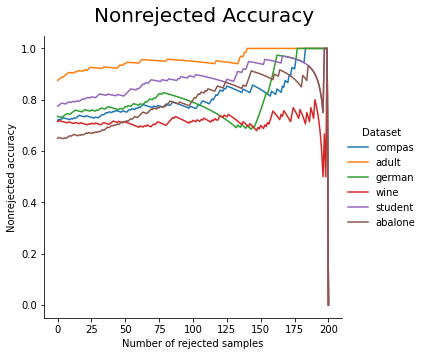

In [13]:
p = sns.relplot(
    data=df_an.melt('r', var_name='Dataset', value_name='vals'), 
    kind="line",
    x="r", y="vals", 
    hue="Dataset"
)
p.figure.subplots_adjust(top=0.9)
p.figure.suptitle(
    "Nonrejected Accuracy",
    fontsize=20,
    fontdict={"weight": "bold"}
)
p.set(xlabel='Number of rejected samples', ylabel='Nonrejected accuracy')
plt.show()
#plt.plot(r_list, german['nonrejected_accuracy'])

In [14]:
max_rej_fraction = 0.6
get_best_tau(adult, 'nonrejected_accuracy', max_rej_fraction)

TypeError: get_best_tau() missing 1 required positional argument: 'max_error'

### Classification quality

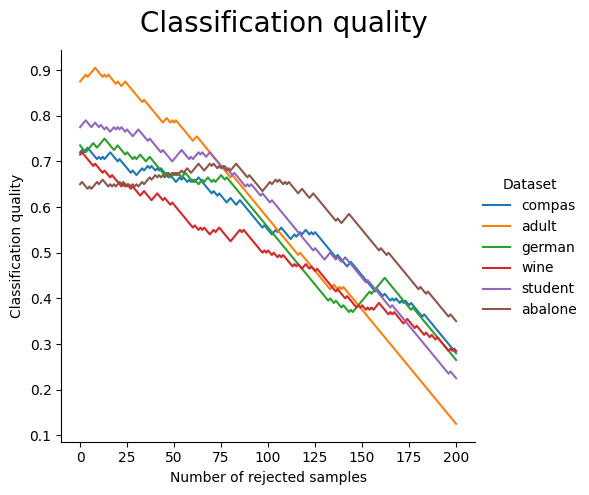

In [15]:
p = sns.relplot(
    data=df_cq.melt('r', var_name='Dataset', value_name='vals'), 
    kind="line",
    x="r", y="vals", 
    hue="Dataset"
)
p.figure.subplots_adjust(top=0.9)
p.figure.suptitle(
    "Classification quality",
    fontsize=20,
    fontdict={"weight": "bold"}
)
p.set(xlabel='Number of rejected samples', ylabel='Classification quality')
plt.show()

### Rejection quality

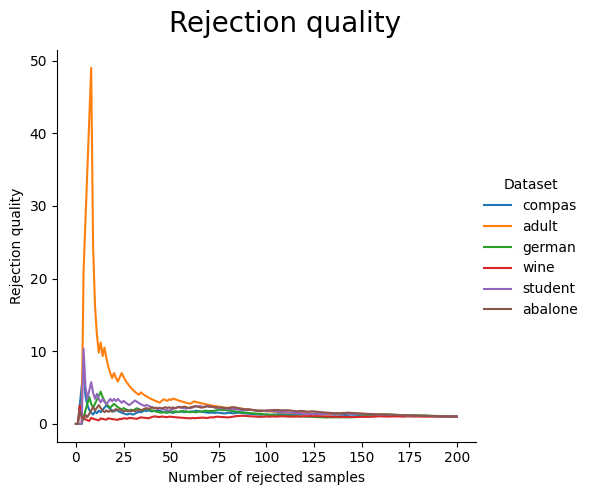

In [16]:
p = sns.relplot(
    data=df_rq.melt('r', var_name='Dataset', value_name='vals'), 
    kind="line",
    x="r", y="vals", 
    hue="Dataset"
)
p.figure.subplots_adjust(top=0.9)
p.figure.suptitle(
    "Rejection quality",
    fontsize=20,
    fontdict={"weight": "bold"}
)
p.set(xlabel='Number of rejected samples', ylabel='Rejection quality')
plt.show()

# Explanation of rejection

## Binary classification

In [11]:
def get_correct_rejected_samples(rej_list, res, d):
    correct_surrogate = []
    for i in rej_list:
        if res[d]['explanation'][i].bb_pred == res[d]['explanation'][i].dt_pred:
            correct_surrogate.append(i)
    print('N samples correctly predicted by the bb: ', len(correct_surrogate))
    return correct_surrogate

### Compas

In [32]:
compas_rej_list = get_rejected_instances(res, 'compas', 'nonrejected_accuracy')
compas_correct_surrogate = get_correct_rejected_samples(compas_rej_list, res, 'compas')
#i = compas_correct_surrogate[0] #2223, 3680
t = explain_rejection(res, 'compas', 3680)
print(t)

Rejection rate:  0.57
N of rejected samples:  114
N samples correctly predicted by the bb:  107
The instance x = 3680 of the dataset COMPAS has been REJECTED.
In fact, it would have been classified by the black-box as did_recid=1 with 0.75 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) did_recid=0: 
	Predicted probabilities: 0: 0.77, 1: 0.23, 
	Changes needed: 
		- race=African-American <= 0.50(original value:1)


In [13]:
for i in compas_correct_surrogate:
    explain_rejection(res, 'compas', i)
    print('')

The instance x = 2508 of the dataset COMPAS has been REJECTED.
In fact, it would have been classified by the black-box as did_recid=0 with 0.55 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) did_recid=1: 
	Predicted probabilities:  0: 0.39,  1: 0.61, 
	Changes needed: 
		- compas_score > 0.52 (original value: 0 )

The instance x = 7427 of the dataset COMPAS has been REJECTED.
In fact, it would have been classified by the black-box as did_recid=1 with 0.58 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) did_recid=0: 
	Predicted probabilities:  0: 0.64,  1: 0.36, 
	Changes needed: 
		- juv_other_count > 0.50 (original value: 0 )

The instance x = 3791 of the dataset COMPAS has been REJECTED.
In fact, it would have been classified by the black-box as did_recid=1 with 0.52 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) did_recid=0:

### Adult

In [33]:
adult_rej_list = get_rejected_instances(res, 'adult', 'nonrejected_accuracy')
adult_correct_surrogate = get_correct_rejected_samples(adult_rej_list, res, 'adult')
if (len(adult_correct_surrogate)) > 0:
    i = adult_correct_surrogate[0]
    t = explain_rejection(res, 'adult', i)
print(t)

Rejection rate:  0.005
N of rejected samples:  1
N samples correctly predicted by the bb:  1
The instance x = 19460 of the dataset ADULT has been REJECTED.
In fact, it would have been classified by the black-box as class=1 with 0.5 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) class=0: 
	Predicted probabilities: 0: 0.6, 1: 0.4, 
	Changes needed: 
		- education-num <= 9.70(original value:10)


### German credit

In [35]:
german_rej_list = get_rejected_instances(res, 'german_credit', 'nonrejected_accuracy')
german_correct_surrogate = get_correct_rejected_samples(german_rej_list, res, 'german_credit')
i = german_correct_surrogate[0]
t = explain_rejection(res, 'german_credit', i)
print(t)

Rejection rate:  0.34
N of rejected samples:  68
N samples correctly predicted by the bb:  67
The instance x = 585 of the dataset GERMAN_CREDIT has been REJECTED.
In fact, it would have been classified by the black-box as default=1 with 0.63 predicted probability, 
but 1 counterfactuals of different classes were found in close proximity:
1) default=0: 
	Predicted probabilities: 0: 0.65, 1: 0.35, 
	Changes needed: 
		- duration_in_month <= 13.01(original value:18)


## Multiclass

### Student

In [17]:
student_rej_list = get_rejected_instances(res, 'student', 'nonrejected_accuracy')
i = student_rej_list[1]
explain_rejection(res, 'student', i)

Rejection rate:  0.535
N of rejected samples:  107
The instance x = 1205 of the dataset STUDENT has been REJECTED.
In fact, it would have been classified by the black-box as Target=1 with 0.58 predicted probability, 
but 2 counterfactuals of different classes were found in close proximity:
1) Target=Graduate: 
	Predicted probabilities:  Dropout: 0.18,  Enrolled: 0.35,  Graduate: 0.47, 
	Changes needed: 
		- Curricular units 2nd sem (approved) > 5.32 (original value: 4.0 )
		- Curricular units 2nd sem (grade) <= 11.49 (original value: 13.62 )
		- Curricular units 1st sem (evaluations) <= 7.90 (original value: 9.0 )
2) Target=Dropout: 
	Predicted probabilities:  Dropout: 0.9,  Enrolled: 0.08,  Graduate: 0.02, 
	Changes needed: 
		- Tuition fees up to date <= 0.80 (original value: 1.0 )


### Abalone

In [18]:
abalone_rej_list = get_rejected_instances(res, 'abalone', 'nonrejected_accuracy')
i = abalone_rej_list[10]
explain_rejection(res, 'abalone', i)

Rejection rate:  0.59
N of rejected samples:  118
The instance x = 706 of the dataset ABALONE has been REJECTED.
In fact, it would have been classified by the black-box as RingsRange=0 with 0.4 predicted probability, 
but 2 counterfactuals of different classes were found in close proximity:
1) RingsRange=13+: 
	Predicted probabilities:  0-8: 0.11,  13+: 0.66,  9-10: 0.23, 
	Changes needed: 
		- Shell weight > 0.10 (original value: 0.08 )
		- Diameter <= 0.23 (original value: 0.25 )
2) RingsRange=9-10: 
	Predicted probabilities:  0-8: 0.32,  13+: 0.22,  9-10: 0.46, 
	Changes needed: 
		- Whole weight > 0.53 (original value: 0.2 )
		- Shucked weight > 0.25 (original value: 0.06 )
		- Shell weight > 0.10 (original value: 0.08 )
		- Diameter > 0.33 (original value: 0.25 )


### Wine

In [19]:
wine_rej_list = get_rejected_instances(res, 'wine', 'nonrejected_accuracy')
multi_c = dict()
for i in wine_rej_list:
    x = res['wine']['explanation'][i]
    n_c_classes = len(x.crules.keys())
    if n_c_classes > 1:
        multi_c[i] = n_c_classes

i = [k for k, v in multi_c.items() if v>2][1]
#i = wine_rej_list[10]
explain_rejection(res, 'wine', i)

Rejection rate:  0.515
N of rejected samples:  103
The instance x = 1508 of the dataset WINE has been REJECTED.
In fact, it would have been classified by the black-box as quality=3 with 0.57 predicted probability, 
but 3 counterfactuals of different classes were found in close proximity:
1) quality=5: 
	Predicted probabilities:  3: 0.01,  4: 0.01,  5: 0.62,  6: 0.31,  7: 0.04,  8: 0.0,  9: 0.0, 
	Changes needed: 
		- volatile acidity > 0.28 (original value: 0.21 )
2) quality=8: 
	Predicted probabilities:  3: 0.01,  4: 0.0,  5: 0.05,  6: 0.41,  7: 0.08,  8: 0.44,  9: 0.0, 
	Changes needed: 
		- free sulfur dioxide > 72.85 (original value: 50.0 )
		- alcohol > 11.87 (original value: 9.8 )
		- density <= 1.00 (original value: 1.0 )
3) quality=7: 
	Predicted probabilities:  3: 0.01,  4: 0.0,  5: 0.06,  6: 0.41,  7: 0.51,  8: 0.01,  9: 0.0, 
	Changes needed: 
		- chlorides <= 0.04 (original value: 0.06 )
		- total sulfur dioxide <= 146.53 (original value: 170.0 )
		- density <= 0.99 (origin